# Introduction
GAN(Generative Adversial Network) is a generative model that is able to generate new content. Two neural networks contest with each other in a game, where one player's gain is another player's loss, a perfect example of this case is the conversion from zebra to horse and vice versa. 
With a training dataset, this technique learns to generate new data with the same statics as the training dataset. 
There are many problems where GAN can be used such as:
- Generating 3D objects
- Face aging
- Image editing
- And many others

# Problem
The chosen problem will be creating faces of anime characters. For this problem, the following dataset was used:  https://github.com/bchao1/Anime-Face-Dataset

This dataset consists of 63632 images, these images will vary in size between 90x90 and 120x120.

#### Imports

In [19]:
# imports
import os
import pandas as pd
import random
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation, LeakyReLU, BatchNormalization, Conv2DTranspose, Reshape, Input, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
import pathlib
import tensorflow_addons as tfa
import sys
from PIL import Image


#### Default Values

In [20]:
# DATASET VALUES
BATCH_SIZE = 128
DATASET_DIRECTORY = "./dataset/cropped/"
IMAGE_SIZE = 64
REMOVED = False

# MODEL VALUES
NOISE_DIM = 100
KERNEL_SIZE = 4
STRIDES = 2

# TRAIN VALUES
EPOCHS = 200


#### Loading dataset

In [21]:
# This dataset has a small problem, there are some corrupted images with a filesize of 0 bytes, so we need to remove them...
if not REMOVED:
    for root, dirs, files in os.walk("dataset"):
      for file in files:
        path = os.path.join(root, file)
        if os.stat(path).st_size == 0:
          print("Removing file:", path)
          os.remove(path)

In [22]:
# Loading dataset
# Every image will be converted to 64x64, making sure they are all the same size
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIRECTORY, label_mode = None, image_size = (IMAGE_SIZE,IMAGE_SIZE) , batch_size=BATCH_SIZE)

# Normalize the dataset
dataset = dataset.map(lambda x: (x /255))

Found 63569 files belonging to 1 classes.


#### Some images from dataset

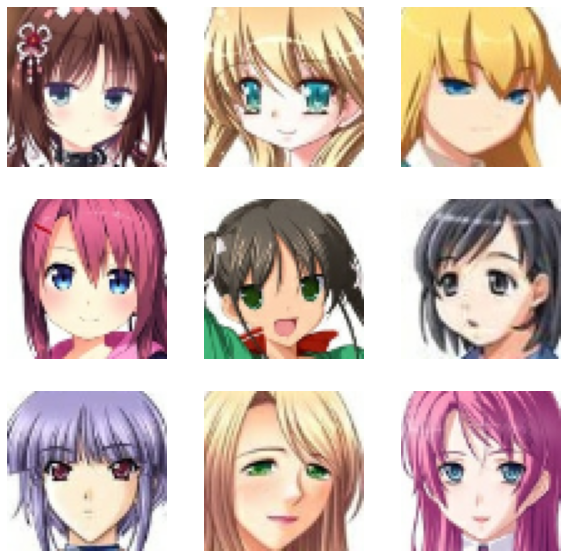

In [23]:
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")


#### Discriminator and Generator
The discriminator is simply a classifier. It tries to distinguish real data from data generated and the generator learns how to create fake data by using feedback from discriminator. It learns to make the discriminator to classify as real.
In discriminator, each block will have an Convolution and in generator, each block will have an Transposed Convolution.


In [24]:
# Discriminator Model
discriminator = tf.keras.Sequential()
# Get as input 28x28x1
discriminator.add(Conv2D(32, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(64, kernel_size= KERNEL_SIZE, strides=STRIDES, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, kernel_size= KERNEL_SIZE, strides=STRIDES, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(256, kernel_size= KERNEL_SIZE, strides=STRIDES, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

# Returns 1x1 as output, if positive then it's a real image, otherwise it's a generated image
discriminator.add(Flatten())
discriminator.add(Dense(1))

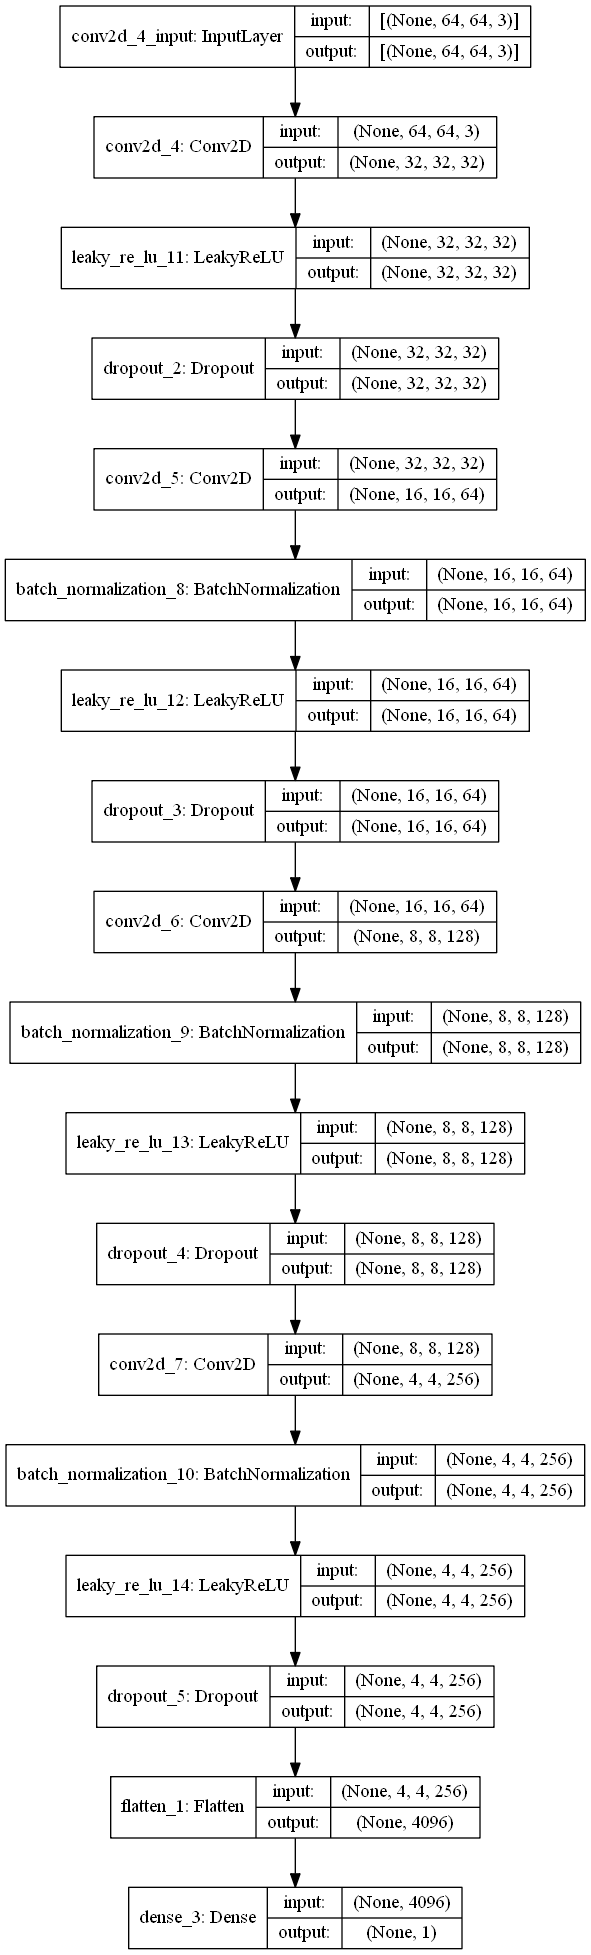

In [25]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [26]:
# Generator Model
generator = tf.keras.Sequential()

generator.add(InputLayer(input_shape=(NOISE_DIM,)))
generator.add(Dense(4*4*256))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Reshape((4, 4, 256)))

generator.add(Conv2DTranspose(128, kernel_size=KERNEL_SIZE, strides=STRIDES,padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(64, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(32, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())


generator.add(Conv2DTranspose(3, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='same', activation='tanh'))


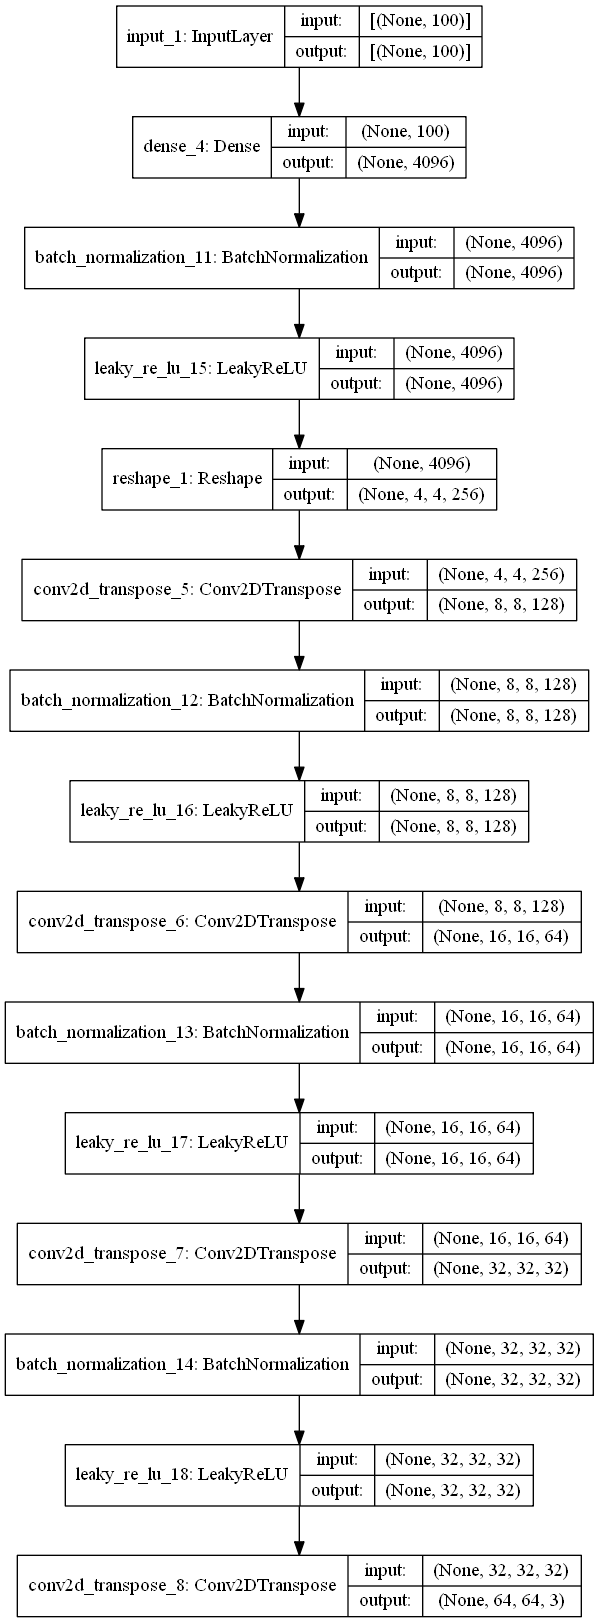

In [27]:
tf.keras.utils.plot_model(generator, show_shapes=True)


#### Generating a face using untrained model
Since this model isn't trained yet, the output will be just noise.

In [28]:
noise = tf.random.normal([1, 100])
generated_face = generator.predict(noise)

(-0.5, 63.5, 63.5, -0.5)

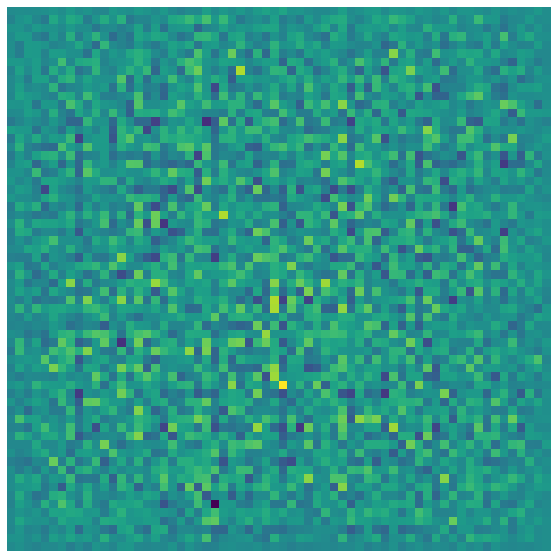

In [29]:
# show predict image
plt.figure(figsize=(10, 10))
plt.imshow(generated_face[0, :, :, 0])
plt.axis("off")

#### Generator and discriminator loss

This method helps to know if the discriminator is able to distinguish which images are true or false.

In [30]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(real_face, fake_face):
    real_loss = cross_entropy(tf.ones_like(real_face), real_face)
    fake_loss = cross_entropy(tf.zeros_like(fake_face), fake_face)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [32]:
def generator_loss(fake_face):
    return cross_entropy(tf.ones_like(fake_face), fake_face)

#### Optimizers

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Train

In [34]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [35]:
def train(dataset):
  gen_loss=0
  dis_loss=0
  gen_plot = []
  dis_plot = []
  for epoch in range(EPOCHS):

    print(f'Epoch = {epoch}, Generator Loss = {gen_loss}, Discriminator Loss = {dis_loss}')
    for image_batch in dataset: 
      gen_loss,dis_loss = train_step(image_batch)
    
    gen_plot.append(gen_loss)
    dis_plot.append(dis_loss)

In [36]:
train(dataset)

Epoch = 0, Generator Loss = 0, Discriminator Loss = 0
Epoch = 1, Generator Loss = 5.881845951080322, Discriminator Loss = 0.09374162554740906
Epoch = 2, Generator Loss = 4.36553955078125, Discriminator Loss = 0.1906527280807495
Epoch = 3, Generator Loss = 4.079451560974121, Discriminator Loss = 0.1515704095363617
Epoch = 4, Generator Loss = 4.003525257110596, Discriminator Loss = 0.45433008670806885
Epoch = 5, Generator Loss = 4.018720626831055, Discriminator Loss = 0.43998345732688904
Epoch = 6, Generator Loss = 3.63380765914917, Discriminator Loss = 0.2084287405014038
Epoch = 7, Generator Loss = 4.349481582641602, Discriminator Loss = 0.13606882095336914
Epoch = 8, Generator Loss = 6.264189720153809, Discriminator Loss = 0.17481419444084167
Epoch = 9, Generator Loss = 3.774043560028076, Discriminator Loss = 0.18726730346679688


In [37]:
num = np.random.randn(32,100)
pred = generator.predict(num)

#### Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

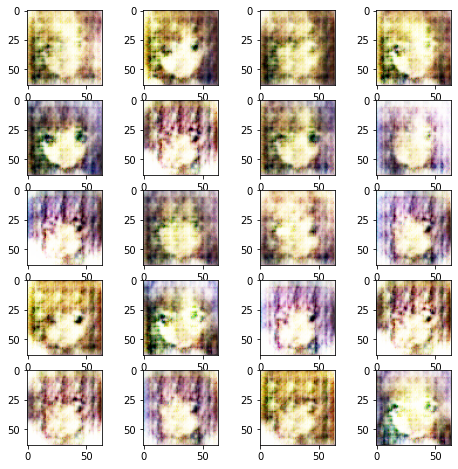

In [38]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()

#### Some results using this model
We were able to generate several examples of anime faces. Obviously, the results are not the best, but to improve these results, it may be necessary to use a different dataset with more images, or use a different model.

- 10 epochs

![<10 epochs>](gan_results/10_epochs.png)

- 30 epochs

![<30 epochs>](gan_results/30_epochs.png)

- 100 epochs

![<100 epochs>](gan_results/100_epochs.png)

- 200 epochs

![<200 epochs>](gan_results/200_epochs.png)